## Customer Analytics 

### Buying Pattern Analysis



In [27]:
import pandas as pd
import numpy as np
import os

try:
    

    df = pd.read_excel('/Users/rajeshpillai/Downloads/Online_Retail.xlsx',skiprows=0,header=0)

    df = df.dropna()

except:
    print('File Not Found')

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      406829 non-null object
StockCode      406829 non-null object
Description    406829 non-null object
Quantity       406829 non-null int64
InvoiceDate    406829 non-null datetime64[ns]
UnitPrice      406829 non-null float64
CustomerID     406829 non-null float64
Country        406829 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.9+ MB


In [29]:
# Add Total by multiplying Quantity and Unit Price

df['Total'] = df.Quantity*df.UnitPrice

# Change date format to YYYYMM

df['DateYMD'] = df.InvoiceDate.dt.strftime('%Y%m%d')


df.head()



,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total,DateYMD
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,20101201
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,20101201
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,20101201
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,20101201
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,20101201


### 2 Country wise distribution

In [30]:
customer_country = df[['Country','CustomerID']]

customer_country = customer_country[~customer_country.duplicated()].reset_index()

customer_country = customer_country\
                                    .sort_values(by=['Country','CustomerID'])
                

customer_country.head()


,index,Country,CustomerID
460,17067,Australia,12386.0
1148,59113,Australia,12388.0
1062,52263,Australia,12393.0
980,45511,Australia,12415.0
1181,63100,Australia,12422.0


### 1. Frequency of Purchase

How often do customers purchase. Buying pattern classified into One-time, Intermittent, Frequent

#### Define Buying Frequency

In [31]:
def buying_freq(count):
    
    if count ==1:
        val = 'one-time'
    
    elif count >6:
        val = 'high-freq'
    
    else :
        val ='intermittent'
    
    return val

#### Define Buying Quantity

In [32]:
def qty_freq(Quantity, qty_analysis):
    
    qty = Quantity
    
    qty_50 = qty_analysis['50%']
    qty_75 = qty_analysis['75%']
    
    if qty <qty_50:
        val = 'low'
    
    elif qty >qty_75:
        val = 'high'
    
    else :
        val ='medium'
    
    return val

#### Analysis

In [33]:
df_invoice_by_customer = df.groupby(by=['CustomerID'])\
                           .InvoiceDate\
                           .nunique()\
                           .reset_index()\
                           .sort_values(by=['InvoiceDate'], ascending=False)


df_invoice_by_customer = df_invoice_by_customer.rename(columns={"InvoiceDate":"Count"})

# Reset Index

df_invoice_by_customer = df_invoice_by_customer.reset_index()

# 5 point summary of data

df_invoice_by_customer.Count.describe()

# 75% of the distribution is below 5. We can split the bins into 1,2-5,6+ sizes

# Write a lamda function to populate the same

count    4372.000000
mean        5.039799
std         9.248607
min         1.000000
25%         1.000000
50%         3.000000
75%         5.000000
max       248.000000
Name: Count, dtype: float64

In [34]:
# Plot the data

s = df_invoice_by_customer.Count

ax = s.plot.kde(bw_method=.5)


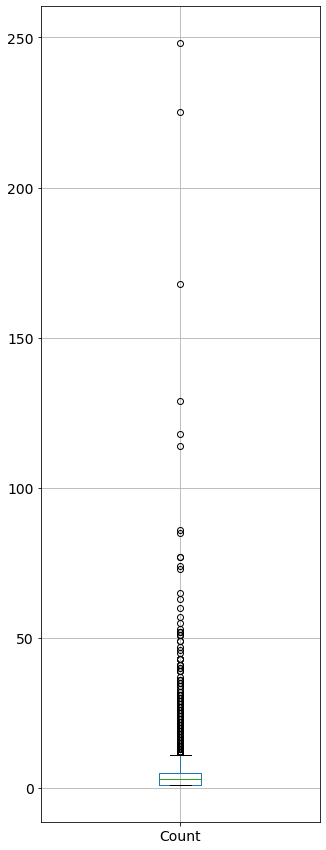

In [53]:
# Boxplot

df_invoice_by_customer.boxplot(column='Count',
                               grid=True,
                               figsize=(5,15),
                               fontsize=14,
                               return_type='axes'
                                      
                              )

In [36]:
# Add New column 'buying_freq'

df_invoice_by_customer['buying_freq'] = df_invoice_by_customer['Count'].apply(buying_freq)

df_invoice_by_customer = df_invoice_by_customer.reset_index()

df_invoice_by_customer.head()

,level_0,index,CustomerID,Count,buying_freq
0,0,1895,14911.0,248,high-freq
1,1,330,12748.0,225,high-freq
2,2,4042,17841.0,168,high-freq
3,3,1674,14606.0,129,high-freq
4,4,2192,15311.0,118,high-freq


### 2 Quantity Analysis

In [37]:
df_quantity_analysis = df.copy()

df_quantity_analysis = df_quantity_analysis[['CustomerID','StockCode','Quantity']]

# Aggregate by Customer

df_quantity_analysis = df_quantity_analysis\
                                        .groupby(by=['CustomerID','StockCode'])\
                                        .Quantity\
                                        .sum()\
                                        .sort_values(ascending=True)\
                                        .reset_index()
# Drop negative quantities as it is not relevant for analysis

df_quantity_analysis = df_quantity_analysis[(df_quantity_analysis.Quantity.sort_values()<5000) & (df_quantity_analysis.Quantity.sort_values()>0)]
                                            

df_quantity_analysis.head()







/Users/rajeshpillai/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


,CustomerID,StockCode,Quantity
2395,16734.0,84674,1
2396,16719.0,22501,1
2397,15039.0,22682,1
2398,16719.0,22468,1
2399,13047.0,23118,1


We see that the outliers beyond 3000 are not required since those transactions have been cancelled out.
So we remove all quantities below 0

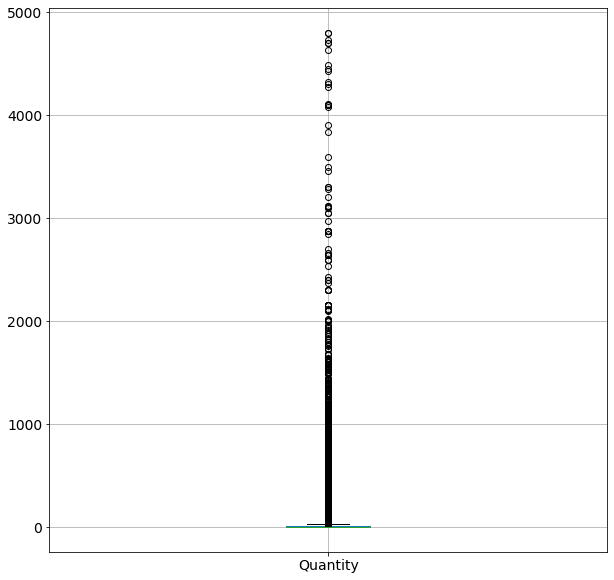

In [38]:
df_quantity_analysis.boxplot(column='Quantity',
                               grid=True,
                               figsize=(10,10),
                               fontsize=14,
                               return_type='axes'
                                      
                              )

In [39]:
#df_quantity_analysis.Quantity.plot.kde()

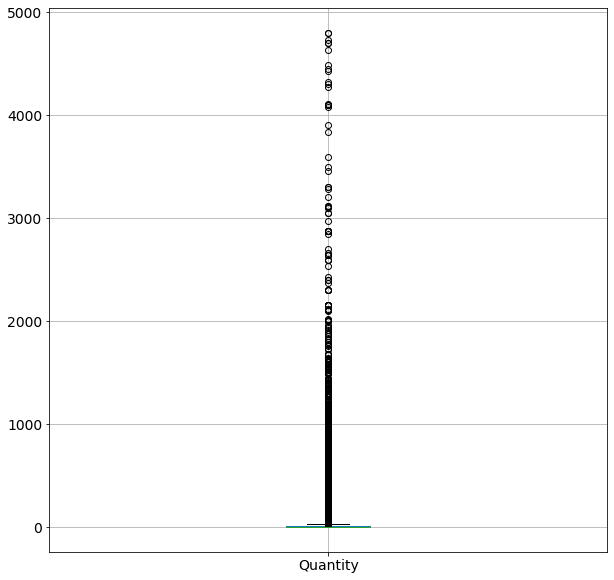

In [40]:
df_quantity_analysis.boxplot(column='Quantity',
                               grid=True,
                               figsize=(10,10),
                               fontsize=14,
                               return_type='axes'
                                      
                              )

In [41]:
qty_analysis = df_quantity_analysis.Quantity.describe().to_dict()

qty_analysis

{'count': 265207.0,
 'mean': 18.20584675366789,
 'std': 77.56141287317637,
 'min': 1.0,
 '25%': 2.0,
 '50%': 6.0,
 '75%': 12.0,
 'max': 4801.0}

In [42]:
qty_analysis['25%']

2.0

count     158.000000
mean       43.873418
std       250.201874
min         1.000000
25%         9.000000
50%        18.000000
75%        18.000000
max      3114.000000
Name: Quantity, dtype: float64

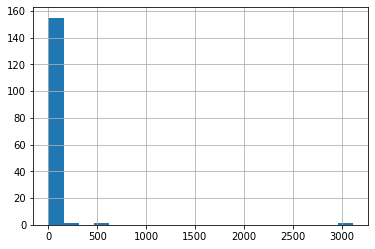

In [43]:
# Product wise quantity distribution

df_quantity_analysis[df_quantity_analysis.StockCode==21108].Quantity.hist(bins=20)


df_quantity_analysis[df_quantity_analysis.StockCode==21108].Quantity.describe()

In [44]:
# Add New column 'qty'


df_quantity_analysis['qty'] = df_quantity_analysis\
                                                  .apply(lambda df_quantity_analysis:qty_freq(df_quantity_analysis['Quantity'],\
                                                    qty_analysis), axis=1)

df_quantity_analysis = df_quantity_analysis.reset_index()

df_quantity_analysis.head()

,index,CustomerID,StockCode,Quantity,qty
0,2395,16734.0,84674,1,low
1,2396,16719.0,22501,1,low
2,2397,15039.0,22682,1,low
3,2398,16719.0,22468,1,low
4,2399,13047.0,23118,1,low


### Basket Analysis

#### a: High b: Mid c: Low

### Analysis

What we explore is to find Customers who buy expensive, mid range and low price items.
In the present analysis we do not have product categorisation, so we cannot compare within individual categories.


In [45]:
def price_range(Price, price_analysis):
    
    price = Price
    
    pr_50 = price_analysis['50%']
    pr_75 = price_analysis['75%']
    
    if price < pr_50:
        val = 'low'
    
    elif price >pr_75:
        val = 'high'
    
    else :
        val ='medium'
    
    return val

In [46]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total,DateYMD
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,20101201
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,20101201
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,20101201
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,20101201
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,20101201


In [47]:
df_price_analysis = df.copy()

df_price_analysis = df_price_analysis[['StockCode','Description','UnitPrice']]

# Aggregate by Customer

df_price_analysis = df_price_analysis\
                                    .groupby(by=['StockCode','Description'])\
                                    .UnitPrice\
                                    .sum()\
                                    .sort_values(ascending=True)\
                                    .reset_index()

# Drop negative or zero price as it is not relevant for analysis

df_price_analysis = df_price_analysis[(df_price_analysis.UnitPrice.sort_values()>1)]

# Shape of data
df_price_analysis.head()

/Users/rajeshpillai/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


,StockCode,Description,UnitPrice
69,84990,60 GOLD AND SILVER FAIRY CAKE CASES,1.10
70,47013C,WINE BOTTLE DRESSING DARK BLUE,1.13
71,79336,LIGHT PINK FLOCK GLASS CANDLEHOLDER,1.14
72,35818B,"ACRYLIC JEWEL ICICLE, BLUE",1.14
73,81950V,FLOWER PURPLE CLOCK WITH SUCKER,1.16


In [48]:
# Price analysis

df_price_analysis['Price'] = df_price_analysis.UnitPrice.round(0).astype('int')

price_analysis = pd.DataFrame(df_price_analysis.Price.unique())

price_analysis = price_analysis[0].describe().to_dict()

price_analysis

{'count': 963.0,
 'mean': 1157.5140186915887,
 'std': 5351.568355479426,
 'min': 1.0,
 '25%': 244.5,
 '50%': 577.0,
 '75%': 1184.0,
 'max': 155508.0}

In [49]:
# Add New column 'price_range'


df_price_analysis['Price_range'] = df_price_analysis\
                                                  .apply(lambda df_price_analysis: \
                                                  price_range(df_price_analysis['Price'],\
                                                  price_analysis), axis=1)

df_price_analysis = df_price_analysis.reset_index(drop=True)

df_price_analysis.head()

,StockCode,Description,UnitPrice,Price,Price_range
0,84990,60 GOLD AND SILVER FAIRY CAKE CASES,1.10,1,low
1,47013C,WINE BOTTLE DRESSING DARK BLUE,1.13,1,low
2,79336,LIGHT PINK FLOCK GLASS CANDLEHOLDER,1.14,1,low
3,35818B,"ACRYLIC JEWEL ICICLE, BLUE",1.14,1,low
4,81950V,FLOWER PURPLE CLOCK WITH SUCKER,1.16,1,low


Question: A customer would have purchased multiple products how we define their affinity as high, medium, low?

We can merge with the transaction table and see the distribution of data

### Market Basket Analysis

First we have to group by the transactions around each invoice number.

In [50]:
df_MBA = df.copy()

df_MBA = df_MBA[['InvoiceNo','StockCode']]

df_MBA = df_MBA.set_index('InvoiceNo')

df_MBA['Purchase_List'] = df_MBA\
                                .groupby('InvoiceNo')\
                                .apply(lambda x: x['StockCode']\
                                                .values\
                                                .tolist()\
                                      )

df_MBA = df_MBA.drop(
                columns=['StockCode'])\
               .reset_index()\
               .drop_duplicates(
                                subset='InvoiceNo', keep='first'
                               )

df_MBA.head()

,InvoiceNo,Purchase_List
0,536365,"[85123A, 71053, 84406B, 84029G, 84029E, 22752,..."
7,536366,"[22633, 22632]"
9,536367,"[84879, 22745, 22748, 22749, 22310, 84969, 226..."
21,536368,"[22960, 22913, 22912, 22914]"
25,536369,[21756]


In [51]:
df2 = df.copy()

df2 = df2[['InvoiceNo','StockCode']].set_index('InvoiceNo')





records = []
for i in range(0, 7501):
    records.append([str(store_data.values[i,j]) for j in range(0, 20)])


NameError: name 'store_data' is not defined

In [ ]:
# Exclude the ones which are below 2 and the one above 10

df_MBA = df_MBA[df_MBA['Purchase_List'].str.len().sort_values()>1]

print('After dropping 1 purchases:', len(df_MBA))

df_MBA = df_MBA[df_MBA['Purchase_List'].str.len().sort_values()<10]

print('After dropping above 10 purchases:', len(df_MBA))

df_MBA.head()

In [ ]:
# Market Basket Analysis

from apyori import apriori

transactions = df_MBA['Purchase_List'].astype('str').values.tolist()


#results = list(apriori(transactions))

association_rules = apriori(
                            transactions, 
                            min_support=0.8,
                            min_confidence =0.8, 
                            min_lift =0.8
                           )

In [ ]:
type(transactions[1])

In [ ]:
df[df.StockCode=='84029E']

In [ ]:
transactions = df_MBA['Purchase_List']

type(transactions)

In [ ]:
########## Testing #############
trans = [
 ['22633', '22632'],
 ['22632', '22633'],
 ['22114', '21733'],
 ['22632', '22633']
]

# Market Basket Analysis

from apyori import apriori


#results = list(apriori(transactions))

association_rules = apriori(trans, 
                            min_support=0.5,
                            min_confidence =0.5, 
                            min_lift =0.2
                           )

association_results = list(association_rules)

print(association_results)

In [ ]:
association_results = list(association_rules)

print(association_results)

In [ ]:
istRules = [list(MB[i][0]) for i in range(0,len(MB))]

In [ ]:
RelationRecord(items=frozenset({' '}),
               support=1.0,
               ordered_statistics=
               [OrderedStatistic(items_base=frozenset(), 
                                 items_add=frozenset({' '}), 
                                 confidence=1.0, 
                                 lift=1.0)]
              )